# Predictive Estimator Demonstration

## Preamble

In [266]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import NeuralNetwork as NN
import Layer
import importlib
import time
from IPython.display import display
from ipywidgets import FloatProgress
from copy import deepcopy
importlib.reload(NN)
importlib.reload(Layer);

if torch.cuda.is_available():
    device = torch.device("cuda:0") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

## Create a Dataset

In [16]:
# Identity
theta = 45./180.*np.pi
R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
def RandomSample():
    r = np.random.rand(2)
    #x = np.round(r)*2. - 1
    x = 2.*r - 1.
    y = R@x #deepcopy(x)
    return [x, y]

In [274]:
# Rotation
delta_theta = 0. #np.pi/2.*np.random.rand()
shift = np.array([0.8, 0.])
print(delta_theta)
def RandomSample():
    r = np.random.rand(2)
    theta = r[0]*2.*np.pi
    rho = r[1]*1.8
    R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    #x = np.round(r)*2. - 1
    x = R@np.array([rho,0]) + shift
    gamma = theta + delta_theta
    R2 = np.array([[np.cos(gamma), -np.sin(gamma)],[np.sin(gamma), np.cos(gamma)]])
    y = R2@np.array([rho,0]) #deepcopy(x)
    return [x, y]

0.0


In [275]:
training_samples = 300
training_input = []
training_output = []
for n in range(training_samples):
    r = RandomSample()
    training_input.append(np.array(r[0], dtype=float))
    training_output.append(np.array(r[1], dtype=float))

training_input = torch.tensor(training_input).float().to(device)
training_output = torch.tensor(training_output).float().to(device)
train = [training_input, training_output]

n_test_samples = 100
test_input = []
test_output = []
r = 0
for n in range(n_test_samples):
    r = RandomSample()
    test_input.append(np.array(r[0], dtype=float))
    test_output.append(np.array(r[1], dtype=float))

test_input = torch.tensor(test_input).float().to(device)
test_output = torch.tensor(test_output).float().to(device)
test = [test_input, test_output]

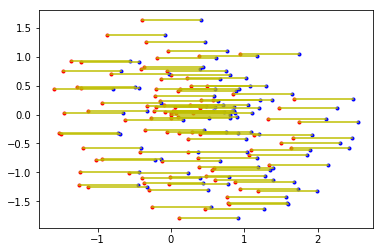

In [276]:
n = 100
plt.plot(np.array(train[1][:n,0]), np.array(train[1][:n,1]), 'r.')
plt.plot(np.array(train[0][:n,0]), np.array(train[0][:n,1]), 'b.')
for k in range(n):
    st = [train[1][k,0], train[0][k,0]]
    en = [train[1][k,1], train[0][k,1]]
    plt.plot(st, en, 'y')

## Create the Neural Network

In [277]:
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=2))
net.AddLayer(Layer.PELayer(n=2))
net.AddLayer(Layer.TopPELayer(n=2))
net.Connect(0,1)
net.Connect(1,2)
net.layers[0].SetActivationFunction('identity')
net.layers[1].SetActivationFunction('identity')
net.layers[2].SetActivationFunction('identity')

In [271]:
net.connections[0].MakeIdentity()
net.connections[1].MakeIdentity()
print(net.connections[1].W)
net.learn_weights = False
net.layers[0].b[0] = 0.8
print(net.layers[0].b)

tensor([[ 1.,  0.],
        [ 0.,  1.]])
tensor([ 0.8000,  0.0000])


## Pre-Training Performance

In [278]:
net.Reset()
yy = net.Predict(1., train[0][:])

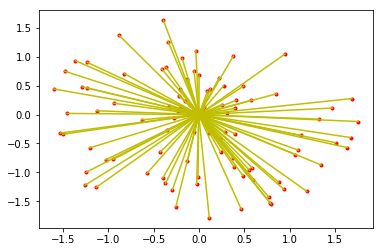

In [279]:
n = 100
plt.plot(np.array(train[1][:n,0]), np.array(train[1][:n,1]), 'r.')
plt.plot(np.array(yy[:n,0]), np.array(yy[:n,1]), 'b.')
for k in range(n):
    st = [train[1][k,0], yy[k,0]]
    en = [train[1][k,1], yy[k,1]]
    plt.plot(st, en, 'y')

## Train

In [280]:
epochs = 1
fp = FloatProgress(min=0,max=epochs*len(train[0]))  
display(fp)
T = 5.
batch_size = 10
net.learning_tau = torch.tensor(batch_size).float().to(device) * 5.
start_time = time.time()
batches = NN.MakeBatches(train[0], train[1], batch_size=batch_size)
for k in range(epochs):
    for x in batches:
        net.Reset()
        net.Infer(T, x[0], x[1])
        fp.value += batch_size
end_time = time.time()
print('Total time: '+str(end_time-start_time))

A Jupyter Widget

Total time: 3.2696690559387207


## Save and/or Load the Model

In [141]:
net.Save('Rotation.npy')

In [155]:
net = NN.NeuralNetwork()
net.Load('Rotation.npy')

## Test Forward Direction

In [282]:
yy = net.Predict(10., test[0][:])

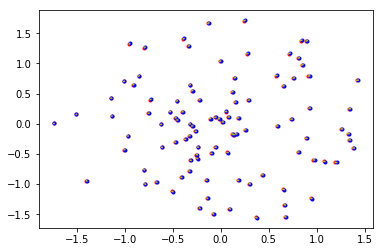

In [283]:
n = len(test[1])
plt.plot(np.array(test[1][:n,0]), np.array(test[1][:n,1]), 'r.')
plt.plot(np.array(yy[:n,0]), np.array(yy[:n,1]), 'b.')
for k in range(n):
    st = [test[1][k,0], yy[k,0]]
    en = [test[1][k,1], yy[k,1]]
    plt.plot(st, en, 'y')

## Backward Direction

In [257]:
xx = net.Generate(10., test[1])

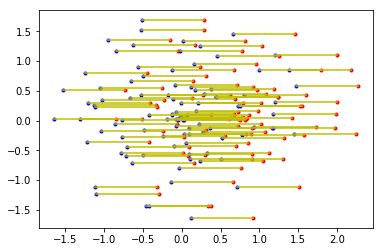

In [258]:
n = 100
plt.plot(np.array(test[0][:n,0]), np.array(test[0][:n,1]), 'r.')
plt.plot(np.array(xx[:n,0]), np.array(xx[:n,1]), 'b.')
for k in range(n):
    st = [test[0][k,0], xx[k,0]]
    en = [test[0][k,1], xx[k,1]]
    plt.plot(st, en, 'y')